In [1]:
import convolution.kernel
import convolution.matrix
from noise import guassian_noise

from signals import rectangle
from domain import equispaced_points
from deconvolution.varpro import variable_projection


import matplotlib.pyplot as plt

from scipy.sparse import spdiags


import numpy as np

In [2]:
t = equispaced_points(512)

In [3]:
latent_signal = rectangle(t)

In [4]:
k1_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=30
)
k2_true = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=15
)

In [5]:
K_true = convolution.matrix.Operator(
    kernel=convolution.kernel.Mixture(
        weights=[0.4,0.6],
        kernels=[k1_true, k2_true]
    ), 
    structure=convolution.matrix.toeplitz
)

In [6]:
convoluted_signal = K_true.image @ latent_signal

In [7]:
percentage = 0.02

In [8]:
noise = guassian_noise(percentage, convoluted_signal)

In [9]:
data = convoluted_signal + noise

In [10]:
k1 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=60
)
k2 = convolution.kernel.Gaussian(
    domain=t, 
    standard_deviation=20
)
K_guess = convolution.matrix.Operator(
    kernel=convolution.kernel.Mixture(
        weights=[0.5, 0.5], 
        kernels=[k1, k2]
    ), 
    structure=convolution.matrix.toeplitz
)

In [11]:
def L(x): 
    return np.identity(x.size)

def rjf_jacobian(K, x): 
    return np.transpose(np.array(K.partial_derivatives) @ x)

In [19]:
def total_variation(x): 
    BETA = 1e-16
    D = forward_difference_matrix(x)
    return np.diag((1/(((D @ x)**2 + BETA**2)**(1/4)))) @ D


def forward_difference_matrix(data): 
    return spdiags([-np.ones_like(data), np.ones_like(data)], [0, 1], data.size, data.size).toarray()

In [39]:
regularization_parameter = 2e-1

In [40]:
K, x, iterations, change = variable_projection(
    data, 
    K_guess, 
    rjf_jacobian,
    regularization_parameter, 
    regularization_matrix=total_variation, 
    maximum_iterations=200,
    signal_guess=data,
    change=1e-16
)
MSE_kernel_guess = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image)**2 / data.size 
MSE_kernel_result = np.linalg.norm(K_true.kernel.image - K.kernel.image)**2 / data.size 
MSE_signal_data = np.linalg.norm(latent_signal - data)**2 / data.size 
MSE_signal_result = np.linalg.norm(latent_signal - x)**2 / data.size 
max_kernel_guess_error = np.linalg.norm(K_true.kernel.image - K_guess.kernel.image, np.inf)
max_kernel_result_error = np.linalg.norm(K_true.kernel.image - K.kernel.image, np.inf)
max_signal_data_error = np.linalg.norm(latent_signal - data, np.inf)
max_signal_result_error = np.linalg.norm(latent_signal - x, np.inf)
print(f'AFTER {iterations} iterations\n\n')
print(f'STOPED when MSE of change in kernel estimate is {change:1.3e}\n\n')
print(f'Regulization parameter: {regularization_parameter}\n\n')
print(f'Standard Deviation (TRUE): {K_true.kernel.variables}')
print(f'Standard Deviation (GUESS): {K_guess.kernel.variables}')
print(f'Standard Deviation (RESULT): {K.kernel.variables}\n\n')
print(f'Mean Squared Error of Kernel (TRUE & GUESS): {MSE_kernel_guess:1.3e}')
print(f'Mean Squared Error of Kernel (TRUE & RESULT): {MSE_kernel_result:1.3e}\n')
print(f'Max error of Kernel (TRUE & GUESS): {max_kernel_guess_error:1.3e}')
print(f'Max error of Kernel (TRUE & RESULT): {max_kernel_result_error:1.3e}\n\n')
print(f'Mean Squared Error of Signal (TRUE & DATA): {MSE_signal_data:1.3e}')
print(f'Mean Squared Error of Signal (TRUE & RESULT): {MSE_signal_result:1.3e}\n')
print(f'Max error of Signal (TRUE & DATA): {max_signal_data_error:1.3e}')
print(f'Max error of Signal (TRUE & RESULT): {max_signal_result_error:1.3e}')


AFTER 148 iterations


STOPED when MSE of change in kernel estimate is 5.544e-25


Regulization parameter: 0.2


Standard Deviation (TRUE): (0.4, 0.6, 30, 15)
Standard Deviation (GUESS): (0.5, 0.5, 60, 20)
Standard Deviation (RESULT): (0.45611480938673593, 0.543885190613264, 27.93767547254289, 14.134910893466126)


Mean Squared Error of Kernel (TRUE & GUESS): 3.099e-06
Mean Squared Error of Kernel (TRUE & RESULT): 1.100e-08

Max error of Kernel (TRUE & GUESS): 7.979e-03
Max error of Kernel (TRUE & RESULT): 5.868e-04


Mean Squared Error of Signal (TRUE & DATA): 1.787e-02
Mean Squared Error of Signal (TRUE & RESULT): 2.399e-03

Max error of Signal (TRUE & DATA): 4.857e-01
Max error of Signal (TRUE & RESULT): 4.353e-01


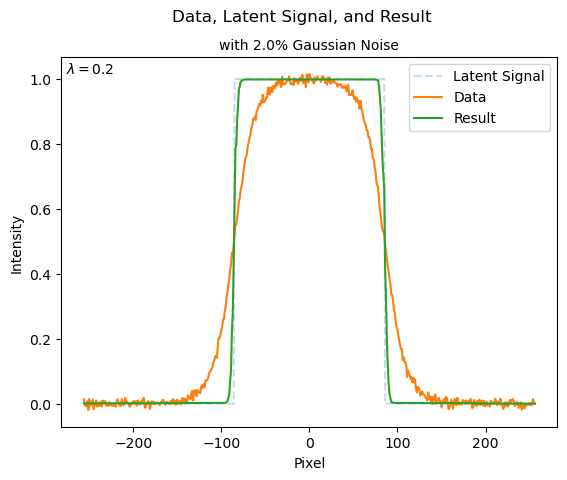

In [41]:
fig, ax = plt.subplots()
plt.suptitle('Data, Latent Signal, and Result')
plt.title(f'with {percentage * 100:}% Gaussian Noise', fontsize=10)
ax.plot(t, latent_signal, '--', label='Latent Signal', alpha=0.25)
ax.plot(t, data, label='Data')
ax.plot(t, x, label='Result')
ax.legend()
ax.text(.01, .99, r'$\lambda = $' + f'{regularization_parameter}', ha='left', va='top', transform=ax.transAxes)
plt.xlabel('Pixel')
plt.ylabel('Intensity');

In [42]:
w1, w2 = K.kernel.weights
k1, k2 = K.kernel.components

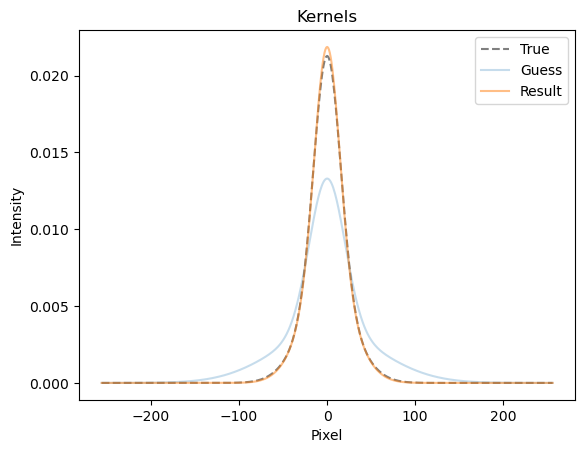

In [43]:
plt.title("Kernels")
plt.plot(t, K_true.kernel.image, 'k--', label='True', alpha=0.5)
plt.plot(t, K_guess.kernel.image, label="Guess", alpha=0.25)
plt.plot(t, K.kernel.image, label='Result', alpha=0.5)
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Intensity');